In [ ]:
import re
import numpy as np
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import lil_matrix
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
#Load Dataset
true_data = pd.read_csv('a1_True.csv')
fake_data = pd.read_csv('a2_Fake.csv')

true_data['Target'] = 'True'
fake_data['Target'] = 'Fake'


data = pd.concat([true_data, fake_data]).sample(frac=1, random_state=42).reset_index(drop=True)
data['label'] = (data['Target'] == 'Fake').astype(int)

print("Dataset shape:", data.shape)
print(data['Target'].value_counts())

Dataset shape: (44899, 6)
Target
Fake    23481
True    21418
Name: count, dtype: int64


In [ ]:
# Clean missing data
true_data.dropna(subset=['title','Target'], inplace=True)
fake_data.dropna(subset=['title','Target'], inplace=True)

In [ ]:
data.head()

,title,text,subject,date,Target,label
0,Trump SHREDS All Remaining Ideas That He’s No...,"Nobody can accuse King Cheeto, a.k.a. Donald T...",News,"July 29, 2016",Fake,1
1,The Adoration Of Kim Jong Un,PYONGYANG - North Koreans stage a demonstratio...,worldnews,"November 30, 2017",True,0
2,BREAKING: RUBIO WINS GOP Senate Nomination In ...,Based on the number of supporters Trump is dra...,politics,"Aug 30, 2016",Fake,1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",True,0
4,Watch What Happens When This Guy Tries To Pic...,"Usually, men have all the advantages they ma...",News,"April 11, 2016",Fake,1


([<matplotlib.patches.Wedge at 0x7aa162aea210>,
 [Text(-1.1968758702781, -0.08653410394775601, 'Fake'),
  Text(1.1968758833443724, 0.08653392322452656, 'True')],
 [Text(-0.6981775909955583, -0.05047822730285767, '52.3%'),
  Text(0.6981775986175505, 0.05047812188097383, '47.7%')])

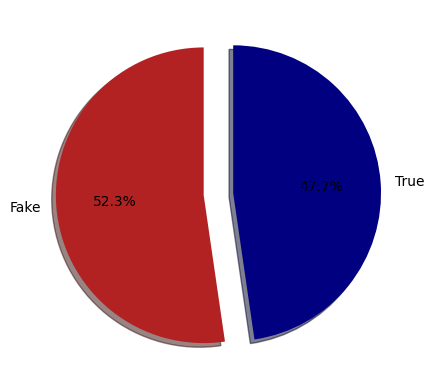

In [ ]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [ ]:
# Preprocess
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()


data['tokens'] = data['text'].apply(preprocess)

In [ ]:
data.head()

,title,text,subject,date,Target,label,tokens
0,Trump SHREDS All Remaining Ideas That He’s No...,"Nobody can accuse King Cheeto, a.k.a. Donald T...",News,"July 29, 2016",Fake,1,"[nobody, can, accuse, king, cheeto, aka, donal..."
1,The Adoration Of Kim Jong Un,PYONGYANG - North Koreans stage a demonstratio...,worldnews,"November 30, 2017",True,0,"[pyongyang, north, koreans, stage, a, demonstr..."
2,BREAKING: RUBIO WINS GOP Senate Nomination In ...,Based on the number of supporters Trump is dra...,politics,"Aug 30, 2016",Fake,1,"[based, on, the, number, of, supporters, trump..."
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",True,0,"[san, francisco, reuters, california, attorney..."
4,Watch What Happens When This Guy Tries To Pic...,"Usually, men have all the advantages they ma...",News,"April 11, 2016",Fake,1,"[usually, men, have, all, the, advantages, the..."


In [ ]:
#Build Vocabulary
all_words = [w for tokens in data['tokens'] for w in tokens]
vocab = sorted(set(all_words))
word2idx = {w: i for i, w in enumerate(vocab)}
vocab_size = len(vocab)
print("Vocab size:", vocab_size)

Vocab size: 212413


In [ ]:
V = len(word2idx)
print(V)

212413


In [ ]:
def compute_tfidf_sparse(tokens_list, word2idx):
    N = len(tokens_list)
    V = len(word2idx)

    # (a) Document Frequency
    df = Counter()
    for tokens in tokens_list:
        for t in set(tokens):
            if t in word2idx:
                df[t] += 1

    # (b) IDF
    idf = np.zeros(V, dtype=np.float32)
    for t, j in word2idx.items():
        idf[j] = np.log((N + 1) / (df[t] + 1)) + 1

    # (c) Sparse TF-IDF
    X = lil_matrix((N, V), dtype=np.float32)
    for i, tokens in enumerate(tokens_list):
        if not tokens:
            continue
        counts = Counter(tokens)
        L = len(tokens)
        for t, c in counts.items():
            if t in word2idx:
                j = word2idx[t]
                X[i, j] = (c / L) * idf[j]
    X = X.tocsr()
    print(f"Sparse TF-IDF shape: {X.shape}, memory ≈ {X.data.nbytes/1e6:.2f} MB")
    return X, idf

In [ ]:
X_sparse, idf_vec = compute_tfidf_sparse(data['tokens'].tolist(), word2idx)
y = data['label'].values.astype(np.float32)

Sparse TF-IDF shape: (44899, 212413), memory ≈ 37.39 MB


In [ ]:
print(X_sparse)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 9346812 stored elements and shape (44899, 212413)>
  Coords	Values
  (0, 0)	0.02728664129972458
  (0, 434)	0.00906477589160204
  (0, 583)	0.008605520240962505
  (0, 1102)	0.02216201461851597
  (0, 1354)	0.014174822717905045
  (0, 1372)	0.012828441336750984
  (0, 1552)	0.008727963082492352
  (0, 1904)	0.008629960007965565
  (0, 3418)	0.008262022398412228
  (0, 3536)	0.005722405388951302
  (0, 4607)	0.01645958423614502
  (0, 5573)	0.014700696803629398
  (0, 6229)	0.011858724988996983
  (0, 6527)	0.009718191809952259
  (0, 6946)	0.019599635154008865
  (0, 7940)	0.022194789722561836
  (0, 9503)	0.013434013351798058
  (0, 9554)	0.008996423333883286
  (0, 9629)	0.014268418774008751
  (0, 9695)	0.0140019990503788
  (0, 9973)	0.010662543587386608
  (0, 10672)	0.007844462059438229
  (0, 11135)	0.012026602402329445
  (0, 11602)	0.01388787291944027
  (0, 12455)	0.01101206336170435
  :	:
  (44898, 197310)	0.012768520042300224
  (44898, 

In [ ]:
print(y)

[1. 0. 1. ... 1. 0. 0.]


In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 7471723 stored elements and shape (35919, 212413)>
  Coords	Values
  (0, 0)	0.03829263523221016
  (0, 2175)	0.0053505077958106995
  (0, 2626)	0.009503980167210102
  (0, 2711)	0.007864921353757381
  (0, 3011)	0.00606101518496871
  (0, 3326)	0.004929639399051666
  (0, 3536)	0.0030886621680110693
  (0, 4099)	0.008352312259376049
  (0, 4350)	0.007297278381884098
  (0, 4357)	0.007907336577773094
  (0, 4482)	0.008307462558150291
  (0, 5025)	0.013270528055727482
  (0, 5646)	0.008422412909567356
  (0, 6851)	0.005082431714981794
  (0, 7129)	0.003892425447702408
  (0, 7776)	0.0020105515141040087
  (0, 7940)	0.022461775690317154
  (0, 8921)	0.008787374012172222
  (0, 9019)	0.00955701619386673
  (0, 9436)	0.008168927393853664
  (0, 9499)	0.006213767919689417
  (0, 9993)	0.013308238238096237
  (0, 10002)	0.008870759978890419
  (0, 10283)	0.006421128287911415
  (0, 10672)	0.004234040156006813
  :	:
  (35918, 186088)	0.00394872110337019
  

In [ ]:
print(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1875089 stored elements and shape (8980, 212413)>
  Coords	Values
  (0, 0)	0.020419755950570107
  (0, 434)	0.00969079602509737
  (0, 1051)	0.010955504141747952
  (0, 2144)	0.026609811931848526
  (0, 2812)	0.01434135902673006
  (0, 7071)	0.018457887694239616
  (0, 7600)	0.05704917013645172
  (0, 7603)	0.07894670218229294
  (0, 7776)	0.01991112530231476
  (0, 7940)	0.017795683816075325
  (0, 8548)	0.007612111512571573
  (0, 10163)	0.013944154605269432
  (0, 11809)	0.00788821093738079
  (0, 12134)	0.018824182450771332
  (0, 12455)	0.003924188669770956
  (0, 14246)	0.028224362060427666
  (0, 16556)	0.0038699167780578136
  (0, 16990)	0.006468761246651411
  (0, 17517)	0.008972899988293648
  (0, 18105)	0.013187593780457973
  (0, 21759)	0.01576199010014534
  (0, 23095)	0.012691096402704716
  (0, 24259)	0.011287597008049488
  (0, 25255)	0.008479097858071327
  (0, 26597)	0.02281573973596096
  :	:
  (8979, 187798)	0.011317627504467964


In [ ]:
# Naive Bayes
class NaiveBayesTorch:
    def __init__(self, eps=1e-9):
        self.eps = eps

    def fit(self, X, y):
        y = np.array(y)
        self.classes = np.unique(y)
        self.class_priors = {c: np.mean(y == c) for c in self.classes}

        self.word_probs = np.zeros((len(self.classes), X.shape[1]), dtype=np.float32)

        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            class_feature_sum = np.array(X_c.sum(axis=0)).flatten()
            smoothed = class_feature_sum + 1.0
            total = smoothed.sum()
            self.word_probs[i] = smoothed / (total + self.eps)

    def predict(self, X):
        preds = []
        log_word_probs = np.log(self.word_probs + 1e-12)
        for i in range(X.shape[0]):
            x = X[i].toarray().flatten()
            scores = []
            for j, c in enumerate(self.classes):
                log_prob = np.sum(log_word_probs[j] * x)
                score = np.log(self.class_priors[c]) + log_prob
                scores.append(score)
            preds.append(self.classes[np.argmax(scores)])
        return np.array(preds)

In [ ]:
# Logistic Regression (PyTorch, Mini-batch)
class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x).squeeze(1)

def train_logistic(model, X_train, y_train, lr=0.01, epochs=100, batch_size=512):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    n = X_train.shape[0]

    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in range(0, n, batch_size):
            batch_idx = idx[i:i+batch_size]
            X_batch = torch.tensor(X_train[batch_idx].toarray(), device=device)
            y_batch = torch.tensor(y_train[batch_idx], dtype=torch.float32, device=device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - loss: {loss.item():.4f}")
    return model

def predict_logistic(model, X, batch_size=512):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, X.shape[0], batch_size):
            X_batch = torch.tensor(X[i:i+batch_size].toarray(), device=device)
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            batch_preds = (probs >= 0.5).long().cpu().numpy()
            preds.extend(batch_preds)
    return np.array(preds)

In [ ]:
# Train Models
print("\nTraining Naive Bayes...")
nb = NaiveBayesTorch()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("\nTraining Logistic Regression (GPU, mini-batches)...")
model = LogisticRegressionTorch(input_dim=X_train.shape[1])
model = train_logistic(model, X_train, y_train, lr=0.01, epochs=100, batch_size=512)
y_pred_lr = predict_logistic(model, X_test)


Training Naive Bayes...

Training Logistic Regression (GPU, mini-batches)...
Epoch 1/100 - loss: 0.4738
Epoch 20/100 - loss: 0.0583
Epoch 40/100 - loss: 0.0479
Epoch 60/100 - loss: 0.0116
Epoch 80/100 - loss: 0.0042
Epoch 100/100 - loss: 0.0027


In [ ]:
#Evaluation
def evaluate(y_true, y_pred, name):
    print(f"\n--- {name} ---")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred, zero_division=0):.4f}")

evaluate(y_test, y_pred_nb, "Naive Bayes")
evaluate(y_test, y_pred_lr, "Logistic Regression (GPU)")


--- Naive Bayes ---
Accuracy : 0.9452
Precision: 0.9392
Recall   : 0.9572
F1 Score : 0.9481

--- Logistic Regression (GPU) ---
Accuracy : 0.9943
Precision: 0.9964
Recall   : 0.9928
F1 Score : 0.9946


In [ ]:
#10. TEST WITH CUSTOM INPUT

def predict_single_text(text, model_nb, model_lr):
    tokens = preprocess(text)
    counts = Counter(tokens)
    L = len(tokens)
    x = lil_matrix((1, len(word2idx)), dtype=np.float32)
    for t, c in counts.items():
        if t in word2idx:
            j = word2idx[t]
            x[0, j] = (c / L) * idf_vec[j]
    x = x.tocsr()

    # Naive Bayes prediction
    pred_nb = model_nb.predict(x)[0]
    # Logistic Regression prediction
    pred_lr = predict_logistic(model_lr, x)[0]

    print("\nInput Text:")
    print(text)
    print("\n Predictions")
    print("Naive Bayes         :", "REAL NEWS " if pred_nb == 1 else "FAKE NEWS ")
    print("Logistic Regression :", "REAL NEWS " if pred_lr == 1 else "FAKE NEWS ")

In [ ]:
sample_text = input("\nEnter any news headline or paragraph to test:\n> ")
predict_single_text(sample_text, nb, model)


Enter any news headline or paragraph to test:
> The Adoration Of Kim Jong Un

Input Text:
The Adoration Of Kim Jong Un

 Predictions
Naive Bayes         : FAKE NEWS 
Logistic Regression : FAKE NEWS 


In [ ]:
import joblib
joblib.dump(nb, "naive_bayes_model.pkl")
torch.save(model.state_dict(), "logistic_model.pt")
np.save("idf_vec.npy", idf_vec)
import json
json.dump(word2idx, open("word2idx.json", "w"))